In [59]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras 
import cv2
import os 
import pandas as pd 

In [60]:
root_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

In [61]:
folders = os.listdir(root_dir)
folders

['benign', 'normal', 'malignant']

In [62]:
folders = ['benign', 'normal', 'malignant']

In [63]:

# Initializing lists to store image paths, labels, and mask paths
image_paths, labels, mask_paths = [], [], []
# Loop over each folder in the dataset
for folder in folders:
    files = os.listdir(os.path.join(root_dir, folder))
    for file in files:
        # Skip files that contain "mask_" in their names
        if "mask_" in file:
            continue
        elif "mask" in file:
            mask_paths.append(os.path.join(root_dir, folder, file))
        # Add image file paths to image_paths list and corresponding labels
        else:
            image_paths.append(os.path.join(root_dir, folder, file))
            labels.append(folder)

In [64]:
# Converting the data as dataframe
df = pd.DataFrame({"image_path": image_paths, "mask_path": mask_paths,"label": labels})

In [65]:
df.head()

,image_path,mask_path,label
0,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,benign
1,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,benign
2,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,benign
3,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,benign
4,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,benign


In [66]:
df['label'].value_counts()

label
benign       437
malignant    210
normal       133
Name: count, dtype: int64

In [67]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
# Load the image, resize it to 128x128, and convert to grayscale
# Convert the image to an array and normalize pixel values to [0, 1]

def load_image(path):
    img = load_img(path, target_size=(128, 128), color_mode='grayscale')
    image_array = img_to_array(img)
    image_array /= 255.
    return image_array

In [68]:
from tqdm import tqdm 
images = []
masks = []

for image_path, mask_path in tqdm(zip(image_paths, mask_paths)):
    image = load_image(image_path)
    images.append(image)

    mask = load_image(mask_path)
    masks.append(mask)

780it [00:09, 81.21it/s]


In [69]:
# Convert lists to numpy arrays
images = np.array(images)
masks = np.array(masks)

In [70]:
# plotting the graphs
def plotting(images, masks):
    plt.figure(figsize=(20, 6))

    for i in range(8):
        idx = np.random.randint(len(images))
        plt.subplot(3, 8, i + 1)
        plt.imshow(images[idx])
        plt.axis("off")
        plt.title(image_paths[idx].split("/")[-1])

        plt.subplot(3, 8, i + 9)
        plt.imshow(masks[idx])
        plt.axis("off")
        plt.title("Mask")

    plt.show()

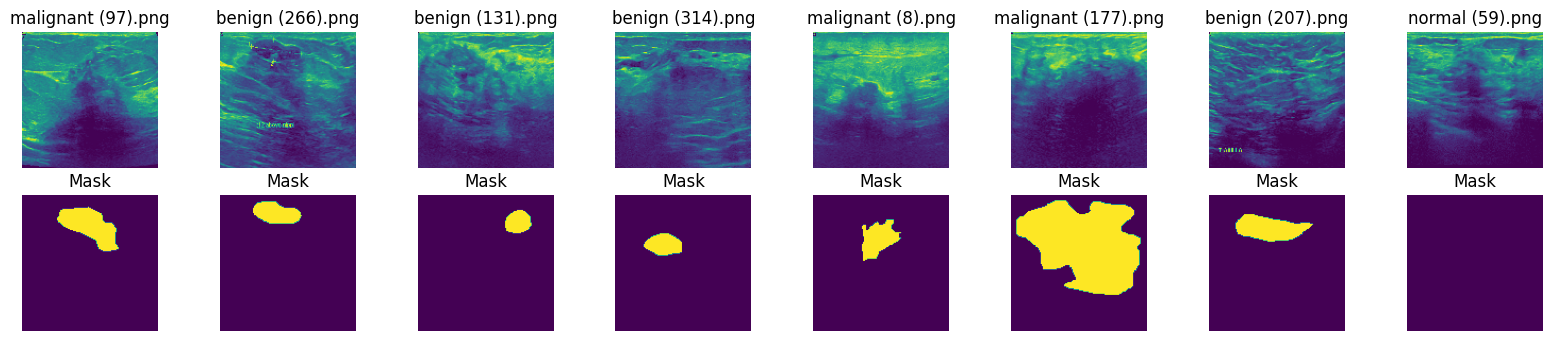

In [71]:
plotting(images,masks)

In [72]:
images[0].shape

(128, 128, 1)

In [73]:
images = images[:-133]
masks = masks[:-133]

In [74]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images, masks, random_state=35, test_size=0.15)

In [75]:
from tensorflow.keras import models, layers
from tensorflow.keras.utils import plot_model

In [76]:
# Function to define a convolutional block
def conv_block(input_layer, num_filters, drop_rate):
    conv = layers.Conv2D(num_filters, (3, 3), activation="elu", padding="same", kernel_initializer="he_normal")(input_layer)
    conv = layers.Dropout((drop_rate))(conv)
    conv = layers.Conv2D(num_filters, (3, 3), activation="elu", padding="same", kernel_initializer="he_normal")(conv)
    return conv

In [77]:
# Function to define an encoder block
def encoder_block(input_layer, num_filters, drop_rate):
    conv = conv_block(input_layer, num_filters, drop_rate)
    maxp = layers.MaxPooling2D((2, 2))(conv)
    return conv, maxp

In [78]:
# Function to define an decoder block
def decoder_block(input_layer, skip_features, drop_rate, num_filters):
    convt = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_layer)
    cnt = layers.concatenate([convt, skip_features])
    conv = conv_block(cnt, num_filters, drop_rate)
    return conv

In [79]:
# Defining the U-Net model architecture
input_layer = layers.Input(shape=(128, 128, 1))

s1, p1 = encoder_block(input_layer, 32, 0.1)
s2, p2 = encoder_block(p1, 64, 0.1)
s3, p3 = encoder_block(p2, 128, 0.2)
s4, p4 = encoder_block(p3, 256, 0.2)
s5, p5 = encoder_block(p4, 512, 0.3)

bottle = conv_block(p5, 1024, 0.3)

d1 = decoder_block(bottle, s5, 0.3, 512)
d2 = decoder_block(d1, s4, 0.2, 256)
d3 = decoder_block(d2, s3, 0.2, 128)
d4 = decoder_block(d3, s2, 0.1, 64)
d5 = decoder_block(d4, s1, 0.1, 32)

output_layer = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d5)

model = models.Model(input_layer, output_layer)

In [80]:
model.compile(optimizer='adam', loss ='binary_crossentropy', metrics =['accuracy'])

In [81]:
history = model.fit(x_train, y_train, validation_data =(x_test,y_test), epochs = 50)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8414 - loss: 0.9687 - val_accuracy: 0.9453 - val_loss: 0.2368
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.9293 - loss: 0.2766 - val_accuracy: 0.9457 - val_loss: 0.1989
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.9316 - loss: 0.2450 - val_accuracy: 0.9457 - val_loss: 0.2021
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.9370 - loss: 0.2217 - val_accuracy: 0.9455 - val_loss: 0.1849
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.9364 - loss: 0.2186 - val_accuracy: 0.9454 - val_loss: 0.1901
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.9298 - loss: 0.2235 - val_accuracy: 0.9457 - val_loss: 0.1804
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.9322 - loss: 0.2169 - val_accuracy: 0.9453 - val_loss: 0.1782
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.9306 - loss: 0.2214 - val_accuracy: 0.94

In [82]:
hist_df = pd.DataFrame(history.history)

In [83]:
hist_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.879578,0.669610,0.945305,0.236813
1,0.933894,0.257757,0.945661,0.198915
2,0.933699,0.236898,0.945653,0.202076
3,0.934071,0.229531,0.945516,0.184940
4,0.934139,0.221448,0.945400,0.190059


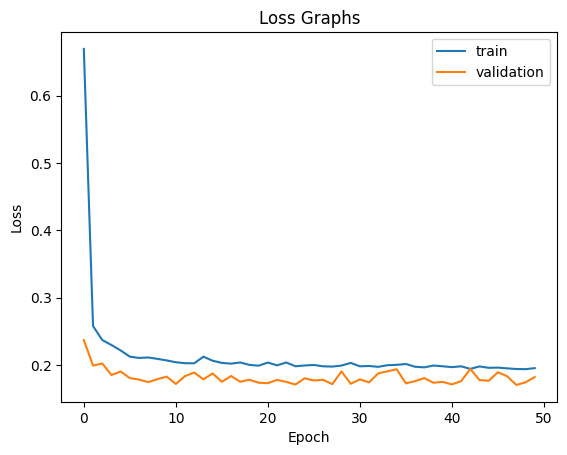

In [88]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "validation"])
plt.title("Loss Graphs")
plt.show()

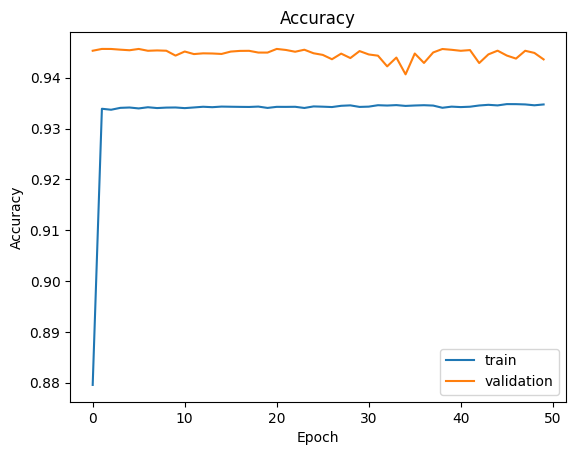

In [87]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "validation"])
plt.title('Accuracy')
plt.show()

In [89]:
prediction = model.predict(x_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 485ms/step


In [101]:
def plot_predictions(preds):
    plt.figure(figsize=(20, 6))

    for i in range(8):
        idx = np.random.randint(len(preds))
        plt.subplot(3, 8, i + 1)
        plt.imshow(x_test[idx],cmap='gray')
        plt.axis("off")
        plt.title("Image")

        plt.subplot(3, 8, i + 9)
        plt.imshow(y_test[idx],cmap='gray')
        plt.axis("off")
        plt.title("Original Mask")

        plt.subplot(3, 8, i + 17)
        plt.imshow(preds[idx],cmap='gray')
        plt.axis("off")
        plt.title("Predicted Mask")

    plt.show()

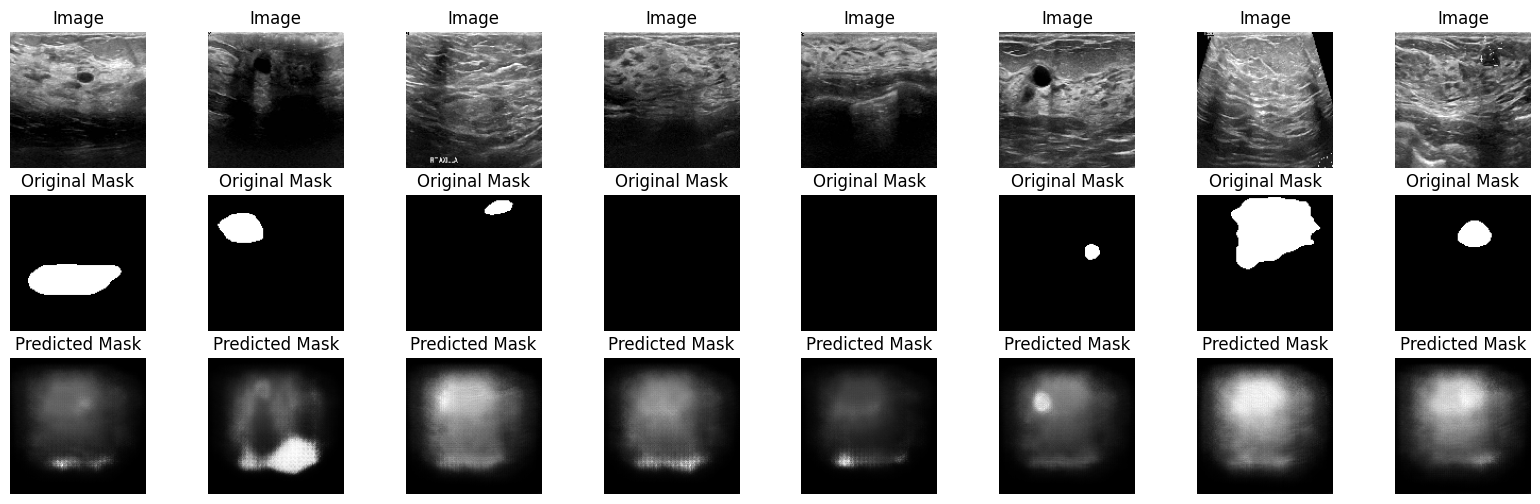

In [102]:
plot_predictions(prediction)